In [1]:
import os
import numpy as np
import mne
import osl
import yaml
from scipy.io import savemat
import matplotlib.pyplot as plt

In [3]:
fif_name = "preproc_preproc_raw.fif"
base = "/gpfs2/well/woolrich/projects/disp_csaky/eeg/"
dataset_path = base + f"session2/preproc0.1_30hz/oslpy/" + fif_name

# load raw data
raw = mne.io.read_raw_fif(dataset_path, preload=True)

# read ica
fif_name = 'preproc_ica.fif'
dataset_path = base + f"session2/preproc0.1_30hz/oslpy/" + fif_name
ica = mne.preprocessing.read_ica(dataset_path)

Opening raw data file /gpfs2/well/woolrich/projects/disp_csaky/eeg/session2/preproc0.1_30hz/oslpy/preproc_preproc_raw.fif...
Isotrak not found
    Range : 0 ... 3068699 =      0.000 ...  3068.699 secs
Ready.
Reading 0 ... 3068699  =      0.000 ...  3068.699 secs...
Reading /gpfs2/well/woolrich/projects/disp_csaky/eeg/session2/preproc0.1_30hz/oslpy/preproc_ica.fif ...
Isotrak not found
Now restoring ICA solution ...
Ready.


In [125]:
sid = str(5)

base = "/gpfs2/well/woolrich/projects/"
dataset_path = base + f"disp_csaky/eeg/session{sid}/task.cdt"
outdir = base + f"disp_csaky/eeg/session{sid}/preproc0.2_30hz"

osl_outdir = os.path.join(outdir, 'oslpy')
report_dir = os.path.join(osl_outdir, 'report')
os.makedirs(report_dir, exist_ok=True)

decim = 10

config_text = """
meta:
    event_codes:
        words/hungry: 2
        words/tired: 3
        words/thirsty: 4
        words/toilet: 5
        words/pain: 6
preproc:
- filter:         {l_freq: 0.2, h_freq: 30, method: 'iir', iir_params: {order: 5, btype: 'bandpass', ftype: 'butter'}}
- bad_channels:   {picks: 'eeg'}
- bad_segments:   {segment_len: 800, picks: 'eeg'}
- ica_raw:        {picks: 'eeg', n_components: 20}
- find_events:    {stim_channel: 'Trigger', min_duration: 0.002}
"""

In [127]:
raw = mne.io.read_raw_curry(dataset_path, preload=True)

# apply this to the Trigger channel: ((x-0.061440)*1e6).astype(np.int32)+1
fun = lambda x: ((x-0.061440)*1e6).astype(np.int32)+1
raw.apply_function(fun, picks=['Trigger'])

# set channel types
raw.set_channel_types({'MAL': 'misc',
                        'MAR': 'misc',
                        'HEO': 'eog',
                        'VEO': 'eog',
                        'EKG': 'ecg',
                        'Trigger': 'stim'})

config = yaml.load(config_text, Loader=yaml.FullLoader)
dataset = osl.preprocessing.run_proc_chain(config,
                                           raw,
                                           outdir=osl_outdir,
                                           overwrite=True,
                                           outname='preproc',
                                           gen_report=False)

preproc : OSL osl_logger: handler 'console' level set to 'INFO'
preproc : logging to file: /gpfs2/well/woolrich/projects/disp_csaky/eeg/session5/preproc0.2_30hz/oslpy/logs/preproc_preproc_raw.log
preproc : 2022-10-13 17:18:25 : Starting OSL Processing
preproc : input : <RawCurry | task.cdt, 69 x 2786700 (2786.7 s), ~1.43 GB, data loaded>
preproc : MNE Stage - raw.filter
preproc : userargs: {'l_freq': 0.2, 'h_freq': 30, 'method': 'iir', 'iir_params': {'order': 5, 'btype': 'bandpass', 'ftype': 'butter'}}


<ipython-input-127-764598ace70f>:8: RuntimeWarning: The unit for channel(s) Trigger has changed from V to NA.
  raw.set_channel_types({'MAL': 'misc',


preproc : OSL Stage - raw : detect_badchannels
preproc : userargs: {'picks': 'eeg'}
preproc : Modality eeg - 7/62 channels rejected     (11.290323%)
preproc : OSL Stage - raw : detect_badsegments
preproc : userargs: {'segment_len': 800, 'picks': 'eeg'}
preproc : detecting zeroed out data from maxfilter log file failed
preproc : Found 50 bad segments
preproc : Modality picks - 65.599000/2786.7 seconds rejected     (2.354003%)
preproc : MNE Stage - mne.preprocessing.ICA
preproc : userargs: {'picks': 'eeg', 'n_components': 20}
preproc : MNE Stage - mne.find_events
preproc : userargs: {'stim_channel': 'Trigger', 'min_duration': 0.002}
preproc : 2022-10-13 17:19:53 : Processing Complete


In [128]:
raw_proc = dataset['raw']
ica = dataset['ica']

In [132]:
ica.exclude = [0, 1, 2, 9]

In [129]:
ica_raw_sources = ica.get_sources(raw_proc)
ica_sources = ica_raw_sources.get_data()

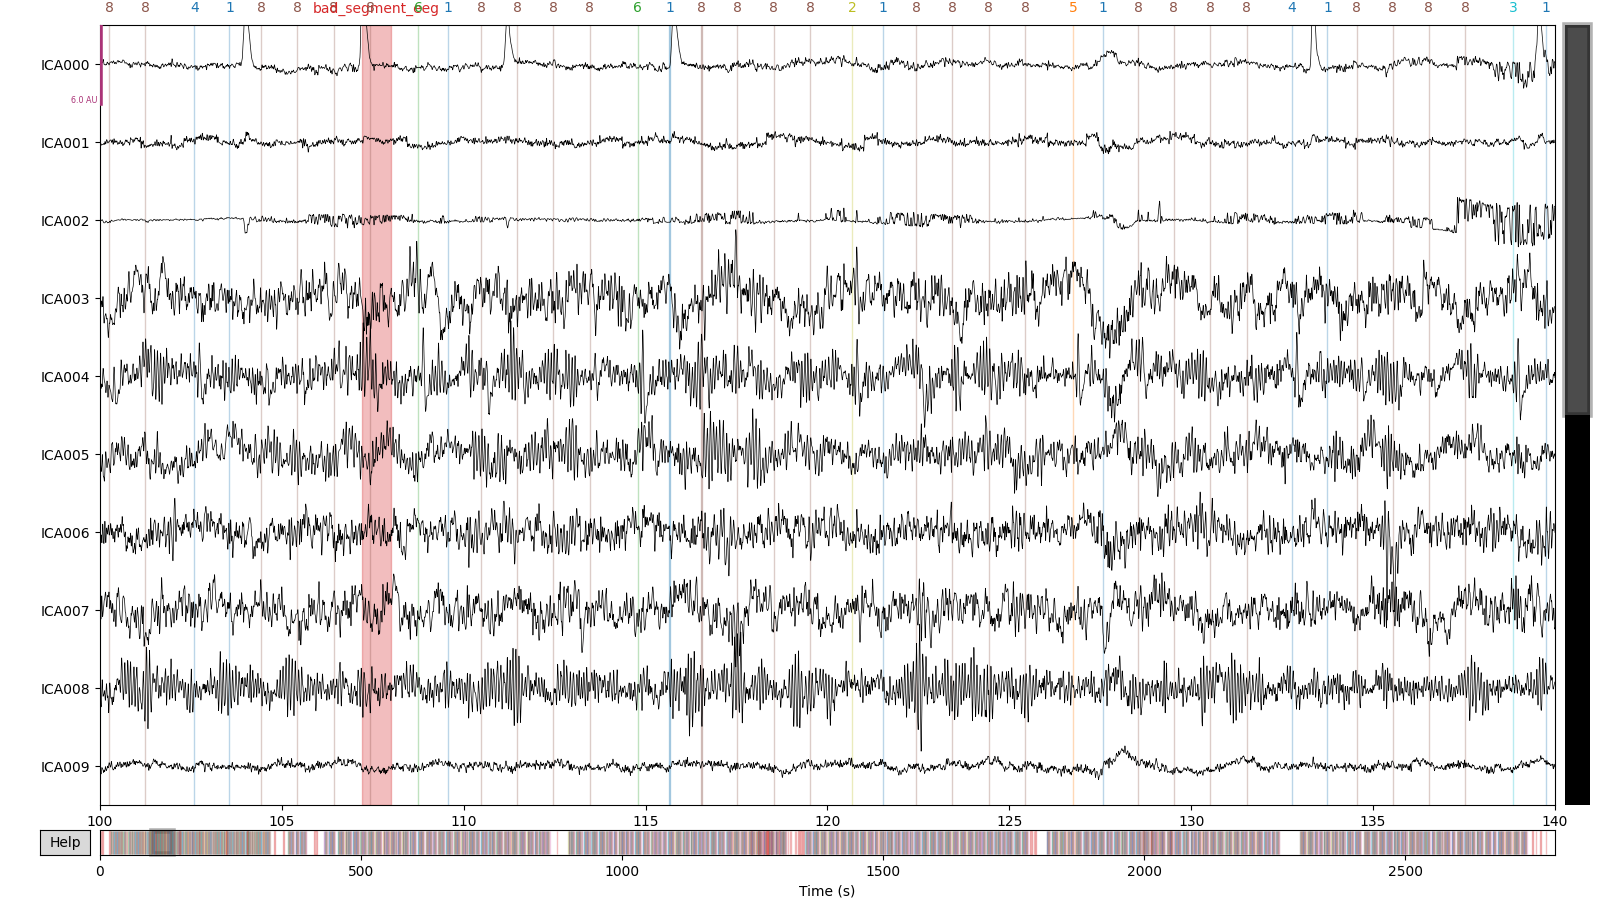

In [131]:
%matplotlib widget
ica_raw_sources.plot(duration=40, start=100, n_channels=10, scalings=3)
e=0

In [ ]:
%matplotlib widget
plt.plot(ica_sources[16][40000:80000], linewidth=0.5)
e=0

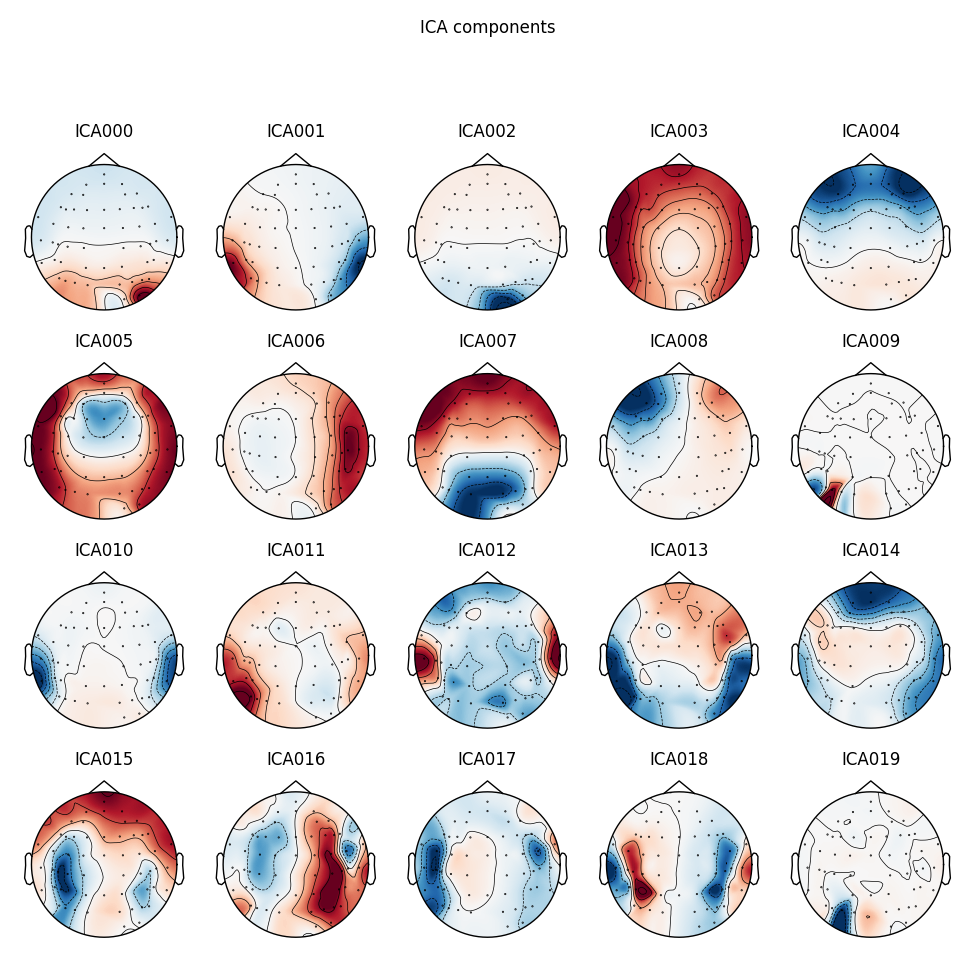

In [130]:
%matplotlib widget
ica.plot_components()
e=0

In [133]:
# apply ICA
ica.apply(raw_proc)

<RawCurry | task.cdt, 69 x 2786700 (2786.7 s), ~1.43 GB, data loaded>

In [134]:
fif_name = "preproc_preproc_raw.fif"
base = "/gpfs2/well/woolrich/projects/disp_csaky/eeg/"
dataset_path = base + f"session{sid}/preproc0.2_30hz/oslpy/" + fif_name

# save raw data
raw_proc.save(dataset_path, overwrite=True)

# save ica
fif_name = 'preproc_ica.fif'
dataset_path = base + f"session{sid}/preproc0.2_30hz/oslpy/" + fif_name
ica.save(dataset_path, overwrite=True)

<ICA | raw data decomposition, method: fastica (fit in 39 iterations on 2721101 samples), 20 ICA components explaining 99.1 % of variance (55 PCA components available), channel types: eeg, 4 sources marked for exclusion>

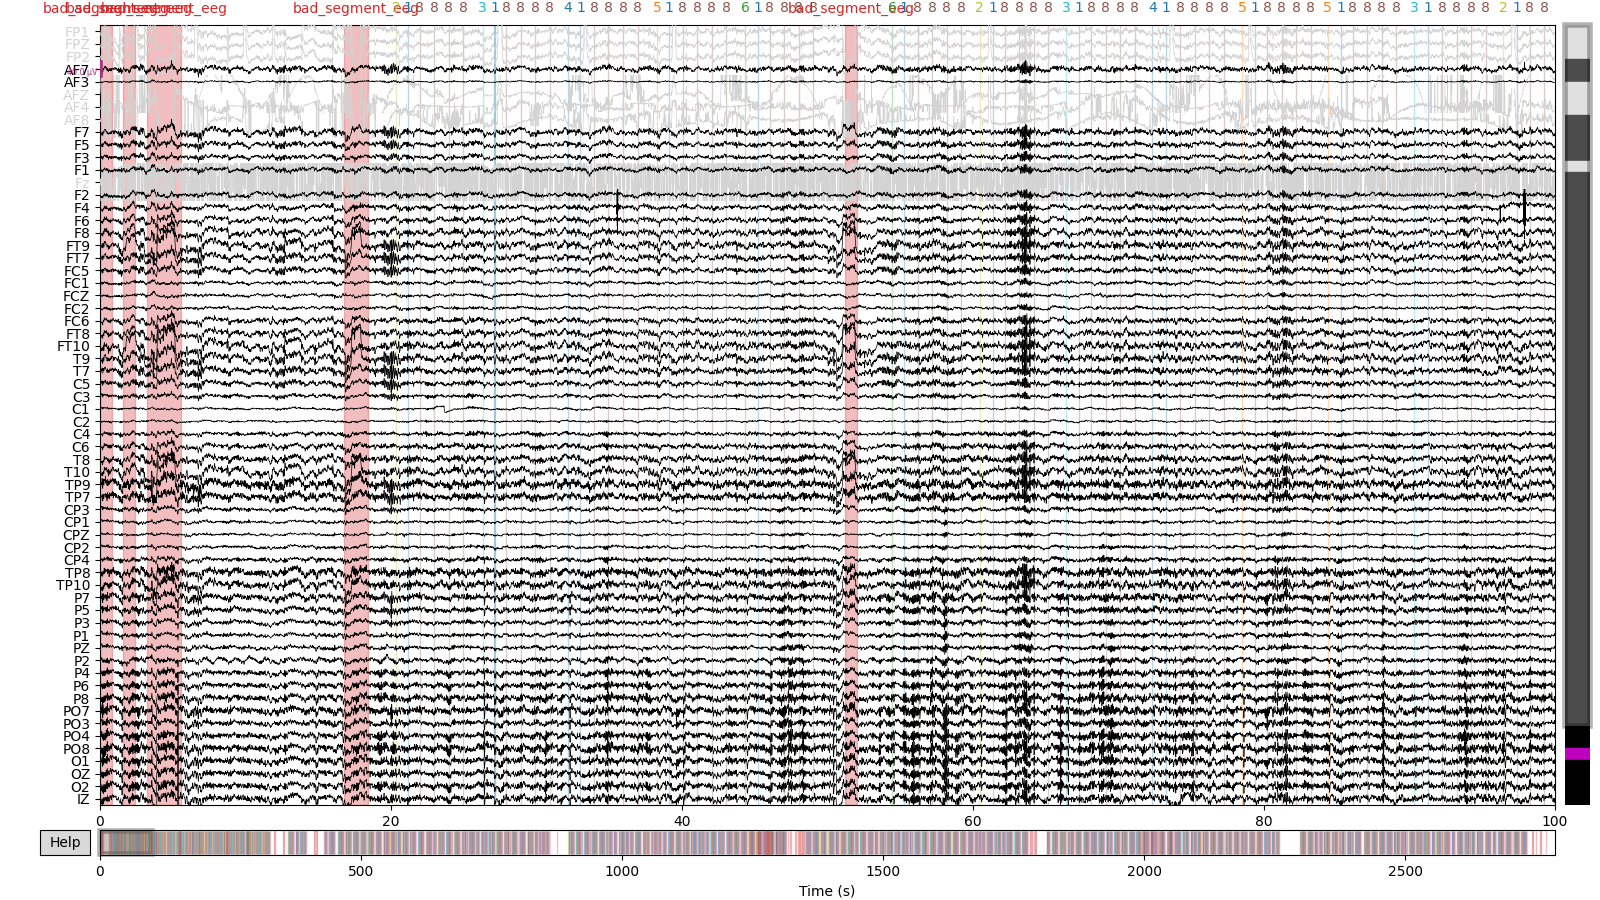

In [136]:
%matplotlib widget
raw_proc.plot(n_channels=62, duration=100)
e=0

In [100]:
raw = mne.io.read_raw_curry(dataset_path, preload=True)

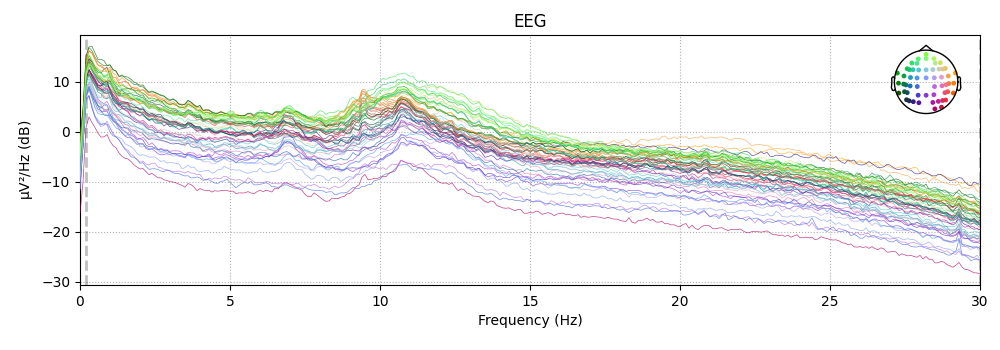

In [135]:
raw_proc.plot_psd(fmax=30, n_fft=10000)
e=0